# Import Packages

In [79]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Define The Three Models

In [80]:
# Define the model
class LSTMCNN:
    def __init__(self, inputh_length, in_channels, mid_channels, out_channels, kernel_size1, kernel_size2, pool_size, number_lstm1, number_lstm2, fc_out, type_model = 'class'):
        self.model = Sequential()
        # First Conv1D layer
        self.model.add(Conv1D(filters=mid_channels, kernel_size=kernel_size1, activation='relu', input_shape=(inputh_length, in_channels)))
        # Second Conv1D layer
        self.model.add(Conv1D(filters=out_channels, kernel_size=kernel_size2, activation='relu'))
        # maxpool
        self.model.add(MaxPooling1D(pool_size=pool_size))
        # LSTM layer
        self.model.add(LSTM(number_lstm1, return_sequences=True, dropout=0.5))

        self.model.add(LSTM(number_lstm2, return_sequences=False, dropout=0.5))

        self.model.add(Dense(fc_out, activation = 'relu'))

        self.model.add(Dense(fc_out, activation = 'relu'))
        
        if type_model == 'class':
            self.model.add(Dense(1, activation = 'sigmoid'))
        if type_model == 'regression':
            self.model.add(Dense(1, activation = 'linear'))

    

class Cnn:
    def __init__(self, inputh_length, in_channels, mid_channels, out_channels, kernel_size1, kernel_size2, pool_size, number_lstm1, number_lstm2, fc_out, type_model = 'class'):
        self.model = Sequential()
        # First Conv1D layer
        self.model.add(Conv1D(filters=mid_channels, kernel_size=kernel_size1, activation='relu', input_shape=(inputh_length, in_channels)))
        # Second Conv1D layer
        self.model.add(Conv1D(filters=out_channels, kernel_size=kernel_size2, activation='relu'))
        # maxpool
        self.model.add(MaxPooling1D(pool_size=pool_size))
        # flatten layer
        self.model.add(Flatten())

        self.model.add(Dense(fc_out, activation = 'relu'))

        self.model.add(Dense(fc_out, activation = 'relu'))
        
        if type_model == 'class':
            self.model.add(Dense(1, activation = 'sigmoid'))
        if type_model == 'regression':
            self.model.add(Dense(1, activation = 'linear'))


class Lstm:
    def __init__(self, inputh_length, in_channels, mid_channels, out_channels, kernel_size1, kernel_size2, pool_size, number_lstm1, number_lstm2, fc_out, type_model = 'class'):
        self.model = Sequential()
    
        self.model.add(LSTM(number_lstm1, return_sequences=True, dropout=0.5))

        self.model.add(LSTM(number_lstm2, return_sequences=False, dropout=0.5))

        self.model.add(Dense(fc_out, activation = 'relu'))

        self.model.add(Dense(fc_out, activation = 'relu'))
        
        if type_model == 'class':
            self.model.add(Dense(1, activation = 'sigmoid'))
        if type_model == 'regression':
            self.model.add(Dense(1, activation = 'linear'))

    



# Define a Class to Perform Project on

In [81]:
class Proj:
    def __init__(self,  inputh_length, in_channels, mid_channels, out_channels, kernel_size1, kernel_size2, pool_size, number_lstm1, number_lstm2, fc_out, type_model = 'class', m = 'lstmcnn'):
        self.loss_reg = 'mse'
        self.loss_class = 'binary_crossentropy'
        self.lstmcnn = LSTMCNN(inputh_length, in_channels, mid_channels, out_channels, kernel_size1, kernel_size2, pool_size, number_lstm1, number_lstm2, fc_out, type_model)
        self.mode = type_model
        self.cnn = Cnn(inputh_length, in_channels, mid_channels, out_channels, kernel_size1, kernel_size2, pool_size, number_lstm1, number_lstm2, fc_out, type_model)
        self.lstm = Lstm(inputh_length, in_channels, mid_channels, out_channels, kernel_size1, kernel_size2, pool_size, number_lstm1, number_lstm2, fc_out, type_model)
        if type_model == 'class':
            self.optimizer = keras.optimizers.Adam()
        else:
            self.optimizer = keras.optimizers.RMSprop()
        if m == 'lstmcnn':
            self.model = self.lstmcnn.model
        elif m == 'lstm':
            self.model = self.lstm.model
        else:
            self.model = self.cnn.model


    def data_loading(self, X, y, X_test, y_test, train_portion = 0.8):
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X, y, train_size = train_portion) 
        self.X_test, self.y_test = X_test, y_test       

    def train(self, epochs = 100, batch_size = 200, call_backs = [], metrics = [], m = 'lstmcnn'):
        if self.mode == 'class':
            self.model.compile(optimizer=self.optimizer, loss=self.loss_class, metrics = metrics)
        else:
            self.model.compile(optimizer=self.optimizer, loss=self.loss_reg, metrics = metrics)
        self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, validation_data=(self.X_val, self.y_val), callbacks = call_backs)
    
    def evaluate(self, batch_size = 200):
        if self.mode == 'class':
            predict = self.model.predict(self.X_test, batch_size=self.X_test.shape[1])
            fpr, tpr, thresholds = roc_curve(self.y_test, predict)
            roc_auc = auc(fpr, tpr)
            epsilon = 0.00001
            tp = keras.metrics.TruePositives(thresholds=0.5)
            fp = keras.metrics.FalsePositives(thresholds=0.5)
            tn = keras.metrics.TrueNegatives(thresholds=0.5)
            fn = keras.metrics.FalseNegatives(thresholds=0.5)
            tp.update_state(self.y_test, predict)
            fp.update_state(self.y_test, predict)
            tn.update_state(self.y_test, predict)
            fn.update_state(self.y_test, predict)
            accuracy = (tp.result() + tn.result()) / (tp.result() + tn.result() + fp.result() + fn.result() + epsilon)
            percision_1, percision_0 = tp.result() / (tp.result() + fp.result() + epsilon), tn.result() / (tn.result() + fn.result() + epsilon)
            recall_1, recall_0 = tp.result() / (tp.result() + fn.result() + epsilon), tn.result() / (tn.result() + fp.result() + epsilon)
            f1_1, f1_0 = 2*recall_1*percision_1 / (recall_1 + percision_1 + epsilon), 2*recall_0*percision_0 / (recall_0+ percision_0 + epsilon)
            predict = np.where(predict >= 0.5, 1, 0)
            confusion_matric = confusion_matrix(self.y_test, predict)
            return {'f1': (f1_1.numpy(), f1_0.numpy()), 'recall': (recall_1.numpy(), recall_0.numpy()), 'percision': (percision_1.numpy(), percision_0.numpy()), 'accuracy': (accuracy.numpy(), accuracy.numpy()), 'cm':confusion_matric, 'roc': (fpr, tpr, roc_auc)}
        else:
            metrics = self.model.evaluate(self.X_test, self.y_test, batch_size=batch_size)
            return metrics
    
    def pred(self, batch_size = 200):
        predict = self.model.predict(self.X_test, batch_size=batch_size)
        return self.y_test, predict
    

        
    

# Data Loading

In [82]:
data = pd.read_csv('./Dataset/train_FD001.csv')
data.drop(['operational setting 3', 'sensor measurement 1', 'sensor measurement 5', 'sensor measurement 10', 'sensor measurement 16', 'sensor measurement 19'], axis = 1, inplace=True)
data = data.iloc[:, 1:]

test_data = pd.read_csv('./Dataset/test_FD001.csv')
help = pd.read_csv('./Dataset/RUL_FD001.csv').iloc[:, 1:]
test_data.drop(['operational setting 3', 'sensor measurement 1', 'sensor measurement 5', 'sensor measurement 10', 'sensor measurement 16', 'sensor measurement 19'], axis = 1, inplace=True)
test_data = test_data.iloc[:, 1:]

In [83]:
def fun(row, df):
    curr_time = row['time in cycles']
    unit = row['unit number']
    last = max(df[df['unit number'] == unit]['time in cycles'])
    return last - curr_time

def fun_test(row, df, help):
    curr_time = row['time in cycles']
    unit = row['unit number']
    last = max(df[df['unit number'] == unit]['time in cycles']) + help[help['unit number'] == unit]['RUL'].values[0]
    return last - curr_time

# RUL and Health Status for Dataset

In [84]:
data['RUL'] = data.apply(lambda row: fun(row, data), axis = 1)
test_data['RUL'] = test_data.apply(lambda row: fun_test(row, test_data, help), axis = 1)

In [85]:
horizon = 50
data['healthy'] = data.apply(func = lambda row: 1 if row['RUL'] > horizon  else  0, axis = 1)
test_data['healthy'] = test_data.apply(func = lambda row: 1 if row['RUL'] > horizon  else  0, axis = 1)

In [86]:
last_window_index = []
before = 1
for i in range(test_data.shape[0] - 1):
    if test_data.iloc[i+1, 0] != before:
        last_window_index.append(i)
        before = test_data.iloc[i+1, 0]
last_window_index.append(test_data.shape[0] - 1)

# Min-Max Scaling

In [87]:
epsilon = 0.00001
min_save = data.iloc[:, :-2].min(axis = 0)
max_save = data.iloc[:, :-2].max(axis = 0)
data.iloc[:, :-2] = (data.iloc[:, :-2] - min_save) / (max_save + epsilon - min_save)
test_data.iloc[:, :-2] = (test_data.iloc[:, :-2] - min_save) / (max_save + epsilon - min_save)

# Feature Seperating

In [88]:
input_length = 30
res = np.array([])
res_test = np.array([])
last_test = np.array([])
for i in range(data.shape[0] - input_length + 1):
    if data.iloc[i+input_length-1, 0] != data.iloc[i, 0]:
        i = i+input_length-1
        continue
    temp = data.iloc[i:i+input_length, 2:20].values
    temp = np.expand_dims(temp, axis = 0)
    if res.size == 0:
        res = temp
    else:
        res = np.concatenate([res, temp], axis = 0)

for i in range(test_data.shape[0] - input_length + 1):
    if test_data.iloc[i+input_length-1, 0] != test_data.iloc[i, 0]:
        i = i+input_length
        continue
    temp = test_data.iloc[i:i+input_length, 2:20].values
    temp = np.expand_dims(temp, axis = 0)
    if res_test.size == 0:
        res_test = temp
    else:
        res_test = np.concatenate([res_test, temp], axis = 0)
    if (i+input_length - 1) in last_window_index:
        if last_test.size == 0:
            last_test = temp
        else:
            last_test = np.concatenate([last_test, temp], axis = 0)


# Seperation of Health

In [89]:
health = np.array([])
for i in range(data.shape[0] - input_length + 1):
    if data.iloc[i+input_length-1, 0] != data.iloc[i, 0]:
        i = i+input_length-1
        continue
    temp_1 = np.array([data.loc[i+input_length-1, 'healthy']])
    health = np.concatenate([health, np.array(temp_1)], axis = 0)
health = health.reshape((-1, 1))

health_test = np.array([])
for i in range(test_data.shape[0] - input_length + 1):
    if test_data.iloc[i+input_length-1, 0] != test_data.iloc[i, 0]:
        i = i+input_length
        continue
    temp_2 = np.array([test_data.loc[i+input_length-1, 'healthy']])
    health_test = np.concatenate([health_test, np.array(temp_2)], axis = 0)
health_test = health_test.reshape((-1, 1))

health_last = np.array([])
for i in range(test_data.shape[0] - input_length + 1):
    if test_data.iloc[i+input_length-1, 0] != test_data.iloc[i, 0]:
        i = i+input_length
        continue
    if (i+input_length - 1) in last_window_index:
        temp_3 = np.array([test_data.loc[i+input_length-1, 'healthy']])
        health_last = np.concatenate([health_last, np.array(temp_3)], axis = 0)
health_last = health_last.reshape((-1, 1))

# Seperation of RUL

In [90]:
rul = np.array([])
for i in range(data.shape[0] - input_length + 1):
    if data.iloc[i+input_length-1, 0] != data.iloc[i, 0]:
        i = i+input_length-1
        continue
    temp = np.array([data.loc[i+input_length-1, 'RUL']])
    rul = np.concatenate([rul, np.array(temp)], axis = 0)
rul = rul.reshape((-1, 1))

rul_test = np.array([])
for i in range(test_data.shape[0] - input_length + 1):
    if test_data.iloc[i+input_length-1, 0] != test_data.iloc[i, 0]:
        i = i+input_length
        continue
    temp_1 = np.array([test_data.loc[i+input_length-1, 'RUL']])
    rul_test = np.concatenate([rul_test, np.array(temp_1)], axis = 0)
rul_test = rul_test.reshape((-1, 1))

rul_last = np.array([])
for i in range(test_data.shape[0] - input_length + 1):
    if test_data.iloc[i+input_length-1, 0] != test_data.iloc[i, 0]:
        i = i+input_length
        continue
    if (i+input_length - 1) in last_window_index:
        temp_3 = np.array([test_data.loc[i+input_length-1, 'RUL']])
        rul_last = np.concatenate([rul_last, np.array(temp_3)], axis = 0)
rul_last = rul_last.reshape((-1, 1))

# Classification without EarlyStopping

In [91]:
project = Proj(30, 18, 32, 64, 5, 3, 3, 50, 50, 200, 'class')
project.data_loading(res, health, res_test, health_test)
project.train(epochs=200)
score_class_no_claaback = project.evaluate()

Epoch 1/200


2024-05-30 21:43:42.433837: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-05-30 21:43:42.477609: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-30 21:43:43.321655: I external/local_xla/xla/service/service.cc:168] XLA service 0x725ed4070660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-30 21:43:43.321677: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-05-30 21:43:43.324936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717092823.375781  145189 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 [==============================] - 4s 16ms/step - loss: 0.3572 - val_loss: 0.2580
Epoch 2/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2375 - val_loss: 0.2205
Epoch 3/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1950 - val_loss: 0.1791
Epoch 4/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1741 - val_loss: 0.1605
Epoch 5/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1644 - val_loss: 0.1654
Epoch 6/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1564 - val_loss: 0.1415
Epoch 7/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1499 - val_loss: 0.1380
Epoch 8/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1413 - val_loss: 0.1334
Epoch 9/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1361 - val_loss: 0.1753
Epoch 10/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1384 - val_loss: 0.1306
Epoch 11/200
71/71 [

In [92]:
score_class_no_claaback_p = {k:score_class_no_claaback[k] for k in score_class_no_claaback.keys() if k not in ['cm', 'roc']}
print(score_class_no_claaback_p)
print('Confusion Matrix:\n', score_class_no_claaback['cm'])

{'f1': (0.98072076, 0.80307525), 'recall': (0.9783029, 0.82392776), 'percision': (0.9831606, 0.7832618), 'accuracy': (0.9648882, 0.9648882)}
Confusion Matrix:
 [[ 730  156]
 [ 202 9108]]


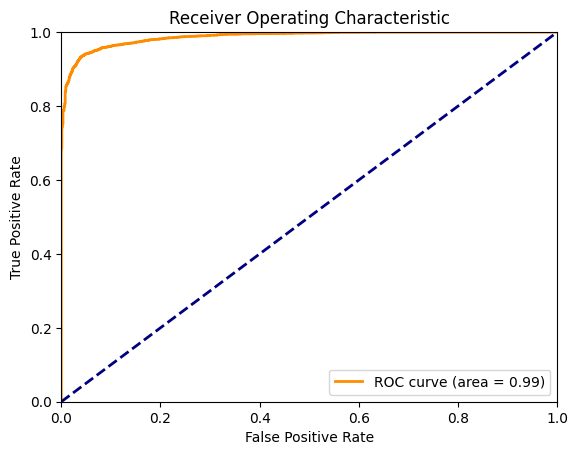

In [93]:
roc = score_class_no_claaback['roc']
plt.figure()
plt.plot(roc[0], roc[1], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./figs/Classification_without_EarlyStopping')
plt.show()

# Classification with EarlyStopping

In [94]:
project = Proj(30, 18, 32, 64, 5, 3, 3, 50, 50, 200, 'class')
project.data_loading(res, health, res_test, health_test)
project.train(epochs=200, call_backs=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)])
score_class_with_callback = project.evaluate()

Epoch 1/200
71/71 [==============================] - 2s 8ms/step - loss: 0.3569 - val_loss: 0.2578
Epoch 2/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2454 - val_loss: 0.2298
Epoch 3/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2079 - val_loss: 0.1597
Epoch 4/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1862 - val_loss: 0.1556
Epoch 5/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1643 - val_loss: 0.1316
Epoch 6/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1602 - val_loss: 0.1535
Epoch 7/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1487 - val_loss: 0.1244
Epoch 8/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1390 - val_loss: 0.1158
Epoch 9/200
71/71 [==============================] - 0s 5ms/step - loss: 0.1412 - val_loss: 0.1151
Epoch 10/200
71/71 [==============================] - 0s 4ms/step - loss: 0.1343 - val_loss: 0.1047
Epoch 11/

In [95]:
score_class_with_callback_p = {k:score_class_with_callback[k] for k in score_class_with_callback.keys() if k not in ['cm', 'roc']}
print(score_class_with_callback_p)
print('Confusion Matrix:\n', score_class_with_callback['cm'])

{'f1': (0.9783245, 0.7621794), 'recall': (0.9819549, 0.7325056), 'percision': (0.9747308, 0.79436964), 'accuracy': (0.9602785, 0.9602785)}
Confusion Matrix:
 [[ 649  237]
 [ 168 9142]]


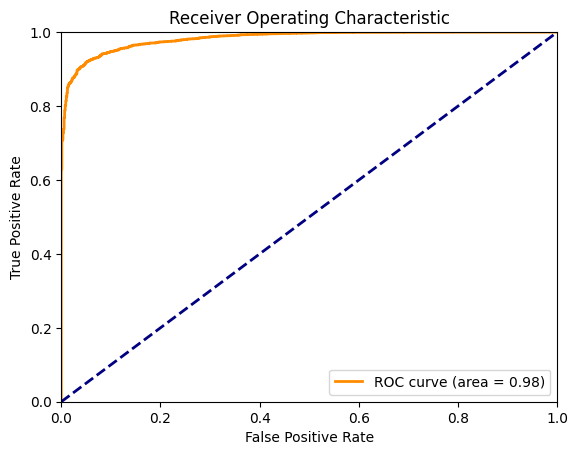

In [96]:
roc = score_class_with_callback['roc']
plt.figure()
plt.plot(roc[0], roc[1], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./figs/Classification_with_EarlyStopping')
plt.show()

# Regression without EarlyStopping

In [97]:
project = Proj(30, 18, 32, 64, 5, 3, 3, 50, 50, 200, 'regression')
project.data_loading(res, rul, res_test, rul_test)
project.train(epochs=200, metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()])
score_reg_no_callback = project.evaluate()
pred = project.pred()

Epoch 1/200
71/71 [==============================] - 2s 8ms/step - loss: 4228.9209 - mean_squared_error: 4228.9209 - root_mean_squared_error: 65.0302 - mean_absolute_error: 49.4685 - mean_absolute_percentage_error: 269062880.0000 - val_loss: 2050.3430 - val_mean_squared_error: 2050.3433 - val_root_mean_squared_error: 45.2807 - val_mean_absolute_error: 36.3666 - val_mean_absolute_percentage_error: 129886032.0000
Epoch 2/200
71/71 [==============================] - 0s 4ms/step - loss: 2020.9562 - mean_squared_error: 2020.9562 - root_mean_squared_error: 44.9550 - mean_absolute_error: 33.8771 - mean_absolute_percentage_error: 83018688.0000 - val_loss: 1869.5115 - val_mean_squared_error: 1869.5115 - val_root_mean_squared_error: 43.2378 - val_mean_absolute_error: 33.8215 - val_mean_absolute_percentage_error: 71947920.0000
Epoch 3/200
71/71 [==============================] - 0s 4ms/step - loss: 1862.9399 - mean_squared_error: 1862.9399 - root_mean_squared_error: 43.1618 - mean_absolute_error:

In [98]:
print('{MSE:', score_reg_no_callback[0], ',RMSE: ', score_reg_no_callback[2], ',MAE:', score_reg_no_callback[3], ',MAPE:', score_reg_no_callback[4], '}')

{MSE: 2188.33203125 ,RMSE:  46.77960968017578 ,MAE: 34.401206970214844 ,MAPE: 28.232784271240234 }


In [99]:
project.X_test, project.y_test = last_test, rul_last
score_reg_no_callback_p = project.evaluate()

1/1 [==============================] - 0s 127ms/step - loss: 654.0885 - mean_squared_error: 654.0885 - root_mean_squared_error: 25.5752 - mean_absolute_error: 19.0098 - mean_absolute_percentage_error: 42.3268


In [100]:
print('Last Window:')
print('{MSE:', score_reg_no_callback_p[0], ',RMSE: ', score_reg_no_callback_p[2], ',MAE:', score_reg_no_callback_p[3], ',MAPE:', score_reg_no_callback_p[4], '}')

Last Window:
{MSE: 654.0885009765625 ,RMSE:  25.575153350830078 ,MAE: 19.009796142578125 ,MAPE: 42.326805114746094 }


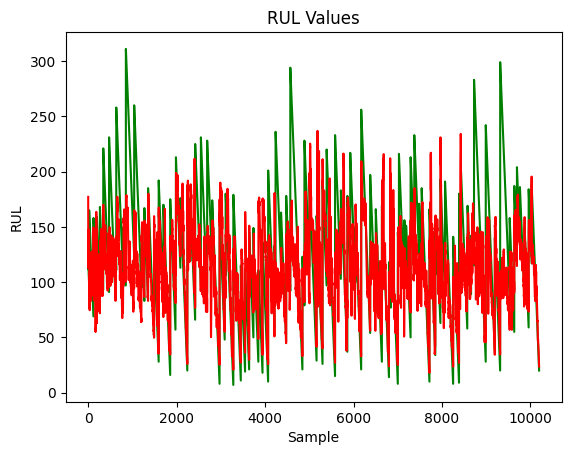

In [101]:
plt.plot(pred[0], color = 'green', label = 'Target')
plt.plot(pred[1], color = 'red', label = 'Pred')
plt.title('RUL Values')
plt.xlabel('Sample')
plt.ylabel('RUL')
plt.savefig('./figs/Regression_without_EarlyStopping')
plt.show()

# Regression with EarlyStopping

In [106]:
project = Proj(30, 18, 32, 64, 5, 3, 3, 50, 50, 200, 'regression')
project.data_loading(res, rul, res_test, rul_test)
project.train(epochs=200, call_backs=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()])
score_reg_with_callback = project.evaluate()
pred = project.pred()

Epoch 1/200
71/71 [==============================] - 2s 8ms/step - loss: 4310.7422 - mean_squared_error: 4310.7422 - root_mean_squared_error: 65.6562 - mean_absolute_error: 50.3663 - mean_absolute_percentage_error: 255190400.0000 - val_loss: 1965.5693 - val_mean_squared_error: 1965.5693 - val_root_mean_squared_error: 44.3347 - val_mean_absolute_error: 33.7544 - val_mean_absolute_percentage_error: 90322072.0000
Epoch 2/200
71/71 [==============================] - 0s 4ms/step - loss: 2054.3762 - mean_squared_error: 2054.3762 - root_mean_squared_error: 45.3252 - mean_absolute_error: 34.2537 - mean_absolute_percentage_error: 77658656.0000 - val_loss: 1782.7007 - val_mean_squared_error: 1782.7007 - val_root_mean_squared_error: 42.2220 - val_mean_absolute_error: 30.8401 - val_mean_absolute_percentage_error: 45249692.0000
Epoch 3/200
71/71 [==============================] - 0s 4ms/step - loss: 1822.1139 - mean_squared_error: 1822.1139 - root_mean_squared_error: 42.6862 - mean_absolute_error: 

In [107]:
print('{MSE:', score_reg_with_callback[0], ',RMSE: ', score_reg_with_callback[2], ',MAE:', score_reg_with_callback[3], ',MAPE:', score_reg_with_callback[4], '}')

{MSE: 1595.0921630859375 ,RMSE:  39.93860626220703 ,MAE: 29.932294845581055 ,MAPE: 26.831504821777344 }


In [108]:
project.X_test, project.y_test = last_test, rul_last
score_reg_with_callback_p = project.evaluate()

1/1 [==============================] - 0s 15ms/step - loss: 700.4482 - mean_squared_error: 700.4482 - root_mean_squared_error: 26.4660 - mean_absolute_error: 20.9531 - mean_absolute_percentage_error: 47.0055


In [109]:
print('Last Window:')
print('{MSE:', score_reg_with_callback_p[0], ',RMSE: ', score_reg_with_callback_p[2], ',MAE:', score_reg_with_callback_p[3], ',MAPE:', score_reg_with_callback_p[4], '}')

Last Window:
{MSE: 700.4481811523438 ,RMSE:  26.46598243713379 ,MAE: 20.953096389770508 ,MAPE: 47.005470275878906 }


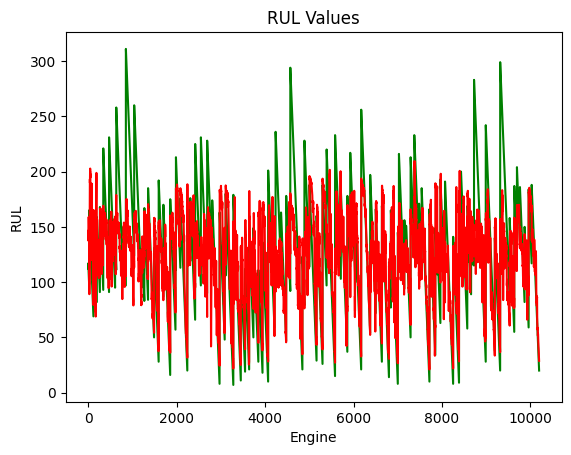

In [110]:
plt.plot(pred[0], color = 'green', label = 'Target')
plt.plot(pred[1], color = 'red', label = 'Pred')
plt.title('RUL Values')
plt.xlabel('Engine')
plt.ylabel('RUL')
plt.savefig('./figs/Regression_with_EarlyStopping')
plt.show()

# LSTM Model Classification with EarlyStopping

In [114]:
project = Proj(30, 18, 32, 64, 5, 3, 3, 50, 50, 200, 'class', m = 'lstm')
project.data_loading(res, health, res_test, health_test)
project.train(epochs=200, call_backs=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)])
lstm_class_with_callback = project.evaluate()

Epoch 1/200
71/71 [==============================] - 2s 8ms/step - loss: 0.3564 - val_loss: 0.2169
Epoch 2/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2697 - val_loss: 0.2475
Epoch 3/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2597 - val_loss: 0.2169
Epoch 4/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2610 - val_loss: 0.2036
Epoch 5/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2547 - val_loss: 0.2047
Epoch 6/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2513 - val_loss: 0.2255
Epoch 7/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2530 - val_loss: 0.2099
Epoch 8/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2472 - val_loss: 0.2153
Epoch 9/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2456 - val_loss: 0.2065
Epoch 10/200
71/71 [==============================] - 0s 4ms/step - loss: 0.2439 - val_loss: 0.2010
Epoch 11/

In [115]:
lstm_class_with_callback_p = {k:lstm_class_with_callback[k] for k in lstm_class_with_callback.keys() if k not in ['cm', 'roc']}
print(lstm_class_with_callback_p)
print('Confusion Matrix:\n', lstm_class_with_callback['cm'])

{'f1': (0.9738897, 0.64367354), 'recall': (0.9937701, 0.50564337), 'percision': (0.95479876, 0.8853755), 'accuracy': (0.9513535, 0.9513535)}
Confusion Matrix:
 [[ 448  438]
 [  58 9252]]


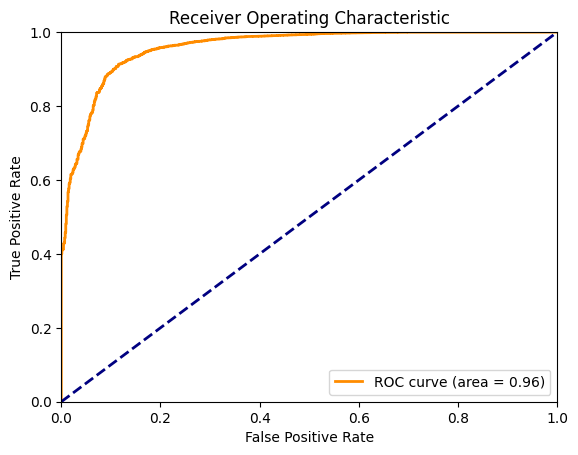

In [116]:
roc = lstm_class_with_callback['roc']
plt.figure()
plt.plot(roc[0], roc[1], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./figs/LSTM_Model_Classification_with_EarlyStopping')
plt.show()

# LSTM Model Regression with EarlyStopping

In [117]:
project = Proj(30, 18, 32, 64, 5, 3, 3, 50, 50, 200, 'regression', m = 'lstm')
project.data_loading(res, rul, res_test, rul_test)
project.train(epochs=200, call_backs=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)], metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()])
lstm_reg_with_callback = project.evaluate()
pred = project.pred()


Epoch 1/200
71/71 [==============================] - 2s 12ms/step - loss: 4698.6089 - mean_squared_error: 4698.6089 - root_mean_squared_error: 68.5464 - mean_absolute_error: 53.1410 - mean_absolute_percentage_error: 368344416.0000 - val_loss: 2045.7643 - val_mean_squared_error: 2045.7643 - val_root_mean_squared_error: 45.2301 - val_mean_absolute_error: 35.9170 - val_mean_absolute_percentage_error: 94922472.0000
Epoch 2/200
71/71 [==============================] - 0s 4ms/step - loss: 2214.2222 - mean_squared_error: 2214.2222 - root_mean_squared_error: 47.0555 - mean_absolute_error: 35.6614 - mean_absolute_percentage_error: 68984248.0000 - val_loss: 1514.8442 - val_mean_squared_error: 1514.8441 - val_root_mean_squared_error: 38.9210 - val_mean_absolute_error: 28.6059 - val_mean_absolute_percentage_error: 20521432.0000
Epoch 3/200
71/71 [==============================] - 0s 4ms/step - loss: 2064.6602 - mean_squared_error: 2064.6599 - root_mean_squared_error: 45.4385 - mean_absolute_error:

In [118]:
print('{MSE:', lstm_reg_with_callback[0], ',RMSE: ', lstm_reg_with_callback[2], ',MAE:', lstm_reg_with_callback[3], ',MAPE:', lstm_reg_with_callback[4], '}')

{MSE: 1855.0462646484375 ,RMSE:  43.07025146484375 ,MAE: 32.149723052978516 ,MAPE: 31.98077392578125 }


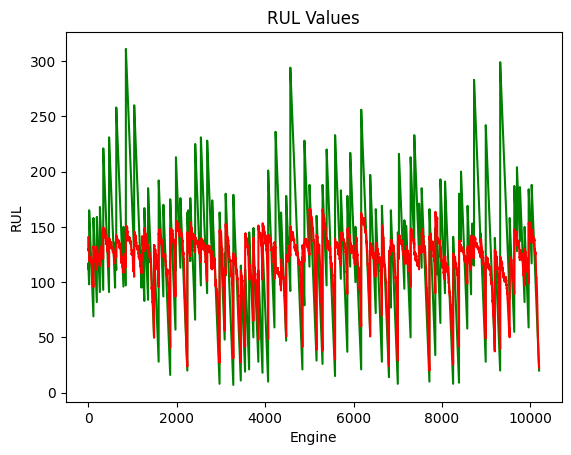

In [119]:
plt.plot(pred[0], color = 'green', label = 'Target')
plt.plot(pred[1], color = 'red', label = 'Pred')
plt.title('RUL Values')
plt.xlabel('Engine')
plt.ylabel('RUL')
plt.savefig('./figs/LSTM_Regression_with_EarlyStopping')
plt.show()

# CNN Model Classification with EarlyStopping

In [120]:
project = Proj(30, 18, 32, 64, 5, 3, 3, 50, 50, 200, 'class', m = 'cnn')
project.data_loading(res, health, res_test, health_test)
project.train(epochs=200, call_backs=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)])
cnn_class_with_callback = project.evaluate()

Epoch 1/200
71/71 [==============================] - 1s 4ms/step - loss: 0.2988 - val_loss: 0.2645
Epoch 2/200
71/71 [==============================] - 0s 2ms/step - loss: 0.2150 - val_loss: 0.1704
Epoch 3/200
71/71 [==============================] - 0s 2ms/step - loss: 0.1475 - val_loss: 0.1298
Epoch 4/200
71/71 [==============================] - 0s 2ms/step - loss: 0.1211 - val_loss: 0.1262
Epoch 5/200
71/71 [==============================] - 0s 2ms/step - loss: 0.1149 - val_loss: 0.1192
Epoch 6/200
71/71 [==============================] - 0s 2ms/step - loss: 0.1216 - val_loss: 0.1043
Epoch 7/200
71/71 [==============================] - 0s 2ms/step - loss: 0.1048 - val_loss: 0.0999
Epoch 8/200
71/71 [==============================] - 0s 2ms/step - loss: 0.0982 - val_loss: 0.0942
Epoch 9/200
71/71 [==============================] - 0s 2ms/step - loss: 0.0970 - val_loss: 0.0884
Epoch 10/200
71/71 [==============================] - 0s 3ms/step - loss: 0.0938 - val_loss: 0.0928
Epoch 11/

In [121]:
cnn_class_with_callback_p = {k:cnn_class_with_callback[k] for k in cnn_class_with_callback.keys() if k not in ['cm', 'roc']}
print(cnn_class_with_callback_p)
print('Confusion Matrix:\n', cnn_class_with_callback['cm'])

{'f1': (0.9810886, 0.8015734), 'recall': (0.9809882, 0.8024831), 'percision': (0.98119897, 0.8006757), 'accuracy': (0.96547663, 0.96547663)}
Confusion Matrix:
 [[ 711  175]
 [ 177 9133]]


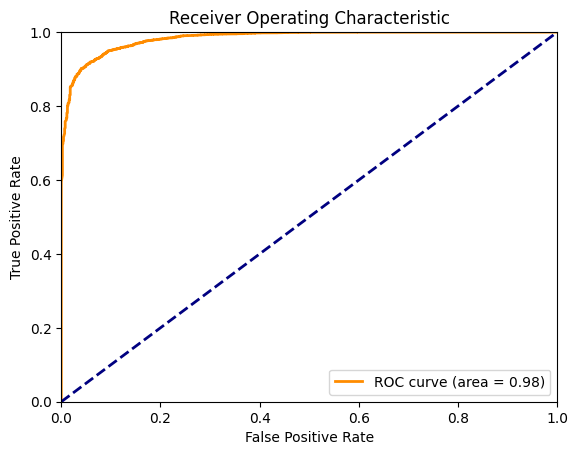

In [122]:
roc = cnn_class_with_callback['roc']
plt.figure()
plt.plot(roc[0], roc[1], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./figs/CNN_Model_Classification_with_EarlyStopping')
plt.show()

# CNN Model Regression with EarlyStopping

In [123]:
project = Proj(30, 18, 32, 64, 5, 3, 3, 50, 50, 200, 'regression', m = 'cnn')
project.data_loading(res, rul, res_test, rul_test)
project.train(epochs=200, call_backs=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)], metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()])
cnn_reg_with_callback = project.evaluate()
pred = project.pred()

Epoch 1/200
71/71 [==============================] - 1s 4ms/step - loss: 3153.5713 - mean_squared_error: 3153.5713 - root_mean_squared_error: 56.1567 - mean_absolute_error: 42.4683 - mean_absolute_percentage_error: 223530288.0000 - val_loss: 1740.6968 - val_mean_squared_error: 1740.6968 - val_root_mean_squared_error: 41.7217 - val_mean_absolute_error: 31.8327 - val_mean_absolute_percentage_error: 25866678.0000
Epoch 2/200
71/71 [==============================] - 0s 2ms/step - loss: 1899.5312 - mean_squared_error: 1899.5312 - root_mean_squared_error: 43.5836 - mean_absolute_error: 32.2710 - mean_absolute_percentage_error: 40736772.0000 - val_loss: 1620.7372 - val_mean_squared_error: 1620.7372 - val_root_mean_squared_error: 40.2584 - val_mean_absolute_error: 29.1272 - val_mean_absolute_percentage_error: 12663227.0000
Epoch 3/200
71/71 [==============================] - 0s 2ms/step - loss: 1809.8374 - mean_squared_error: 1809.8374 - root_mean_squared_error: 42.5422 - mean_absolute_error: 

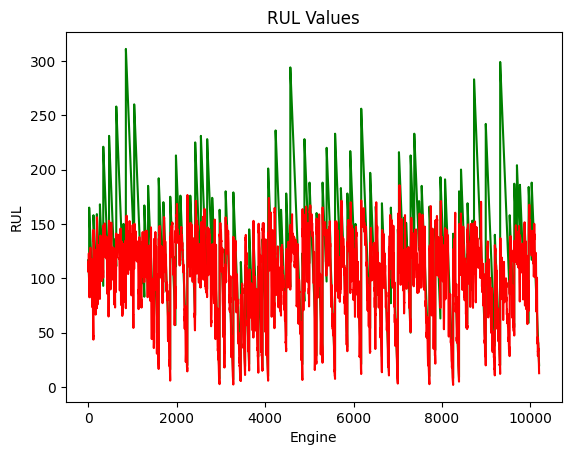

In [124]:
plt.plot(pred[0], color = 'green', label = 'Target')
plt.plot(pred[1], color = 'red', label = 'Pred')
plt.title('RUL Values')
plt.xlabel('Engine')
plt.ylabel('RUL')
plt.savefig('./figs/CNN_Regression_with_EarlyStopping')
plt.show()

In [125]:
print('{MSE:', cnn_reg_with_callback[0], ',RMSE: ', cnn_reg_with_callback[2], ',MAE:', cnn_reg_with_callback[3], ',MAPE:', cnn_reg_with_callback[4], '}')

{MSE: 2036.716796875 ,RMSE:  45.1299934387207 ,MAE: 32.11378479003906 ,MAPE: 23.738597869873047 }
